In [1]:
#api: 6N4PFA0IR156G2M8

In [78]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

def get_stock_data(symbol, api_key):
    base_url = "https://www.alphavantage.co/query"
    function = "TIME_SERIES_DAILY"
    query_params = {
        "function": function,
        "symbol": symbol,
        "apikey": api_key,
        "outputsize": "full"
    }

    response = requests.get(base_url, params=query_params)
    if response.status_code == 200:
        return response.json()
    else:
        return None
def filter_data_by_date_range(data, start_date, end_date):
    """
    Filters the stock data to only include entries within the given start and end dates.

    :param data: The complete stock data returned by Alpha Vantage.
    :param start_date: The start date as a string in YYYY-MM-DD format.
    :param end_date: The end date as a string in YYYY-MM-DD format.
    :return: Filtered data as a dictionary.
    """
    time_series = data.get("Time Series (Daily)", {})
    filtered_data = {date: details for date, details in time_series.items() if start_date <= date <= end_date}
    return filtered_data
def create_dataframe(stock_data):
    """
    Creates a pandas DataFrame from the stock data.

    :param stock_data: The stock data returned by Alpha Vantage.
    :return: A pandas DataFrame.
    """
    # Extract the time series data

    # Convert the time series into a DataFrame
    df = pd.DataFrame(stock_data).T  # Transpose to have dates as rows

    # Convert column names and data types
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].astype(float)
    df['Volume'] = df['Volume'].astype(int)

    # Convert the index to datetime
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    return df

api_key = "6N4PFA0IR156G2M8"
stock_symbol = "AAPL"
start_date = "2020-01-01"
end_date = "2023-03-31"
# Fetch the stock data
stock_data = get_stock_data(stock_symbol, api_key)
stock_data = filter_data_by_date_range(stock_data, start_date, end_date)
stock_df = create_dataframe(stock_data)

In [71]:
AAPL = stock_df.loc[:,["Close"]]
#Factor Excess Returns
#From:mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html (divided by 100 as KF reports in percent)
market = pd.read_csv("F-F_Research_Data_Factors_daily.CSV",header = 3,index_col=0)
#only get MKT data and RF data
market = market.iloc[:-1,[0,3]]
market.index = pd.to_datetime(market.index)
market


,Mkt-RF,RF
1926-07-01,0.10,0.009
1926-07-02,0.45,0.009
1926-07-06,0.17,0.009
1926-07-07,0.09,0.009
1926-07-08,0.21,0.009
...,...,...
2024-02-23,0.02,0.021
2024-02-26,-0.26,0.021
2024-02-27,0.27,0.021
2024-02-28,-0.26,0.021


In [72]:
AAPL

,Close
2020-01-02,300.35
2020-01-03,297.43
2020-01-06,299.80
2020-01-07,298.39
2020-01-08,303.19
...,...
2023-03-27,158.28
2023-03-28,157.65
2023-03-29,160.77
2023-03-30,162.36


In [73]:
AAPL = AAPL.join(market,how="inner")
AAPL

,Close,Mkt-RF,RF
2020-01-02,300.35,0.86,0.006
2020-01-03,297.43,-0.67,0.006
2020-01-06,299.80,0.36,0.006
2020-01-07,298.39,-0.19,0.006
2020-01-08,303.19,0.47,0.006
...,...,...,...
2023-03-27,158.28,0.27,0.016
2023-03-28,157.65,-0.17,0.016
2023-03-29,160.77,1.39,0.016
2023-03-30,162.36,0.50,0.016


Task2

In [76]:
import statsmodels.api as sm

y = AAPL["Close"] - AAPL["RF"]
X = AAPL[["Mkt-RF"]]

X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())
# β值为X的系数
beta = results.params['Mkt-RF']

# α值为常数项的系数，这里表示超额收益
alpha = results.params['const']

print(f'Alpha (α): {alpha:.4f}')
print(f'Beta (β): {beta:.4f}')


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.363
Date:                Thu, 04 Apr 2024   Prob (F-statistic):              0.243
Time:                        03:55:42   Log-Likelihood:                -4770.7
No. Observations:                 818   AIC:                             9545.
Df Residuals:                     816   BIC:                             9555.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        182.4224      2.890     63.115      0.0

Task3

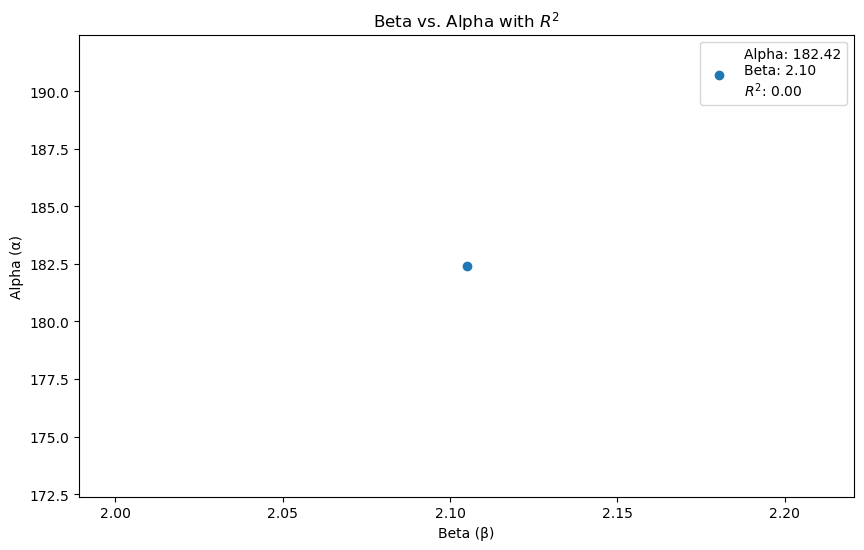

In [80]:
r_squared = results.rsquared

# 可视化α、β和R^2值
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(beta, alpha, label=f'Alpha: {alpha:.2f}\nBeta: {beta:.2f}\n$R^2$: {r_squared:.2f}')
ax.set_title('Beta vs. Alpha with $R^2$')
ax.set_xlabel('Beta (β)')
ax.set_ylabel('Alpha (α)')
ax.legend()

plt.show()